In [1]:
# %pip install requests
# %pip install pandas
# %pip install numpy
# %pip install keras
# %pip install matplotlib


In [2]:
import os
import requests
import csv
import datetime

start_time = "2023-01-01 00:00:00"
limit = 1000

# Convert start time to milliseconds
start_time_ms = int(datetime.datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S").timestamp() * 1000)

# Convert milliseconds to a datetime object
start_obj = datetime.datetime.fromtimestamp(start_time_ms / 1000)

# Add the number of hours to the datetime object
end_obj = start_obj + datetime.timedelta(hours=limit-1)

# Convert the updated datetime object back to milliseconds
end_time_ms = int(end_obj.timestamp() * 1000)

# Convert milliseconds to a datetime object
end_obj = datetime.datetime.fromtimestamp(end_time_ms / 1000)

# Convert datetime object to a string in the desired format
end_time = end_obj.strftime('%Y-%m-%d %H:%M:%S')


print(start_time_ms, "-" ,end_time_ms)
print(start_time, "-" ,end_time)

1672531200000 - 1676127600000
2023-01-01 00:00:00 - 2023-02-11 15:00:00


In [3]:

# set the API endpoint and parameters
url = 'https://api.binance.com/api/v3/klines'

headers = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

def get_data(symbol, dateframe, start_time_ms, path='data/', limit=1000):
    params = {
        'symbol': symbol,  # cryptocurrency and trading pair
        'interval': dateframe,  # time interval (1h, 4h, 1d, etc.)
        'startTime': start_time_ms,  # start time in milliseconds
        'limit': limit
    }

    # send a GET request to the API endpoint with the parameters
    response = requests.get(url, params=params)

    # parse the response data and save it to a CSV file
    data = response.json()
    
    if not os.path.exists(path):
        os.makedirs(path)

    with open(f'{path}/{symbol.lower()}_data_{start_time_ms}.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        for row in data:
            writer.writerow(row[:len(headers)])

symbol = 'BTCUSDT'
timeframe = '1h'
path = 'data/'

get_data(symbol, timeframe, start_time_ms)
get_data(symbol, timeframe, end_time_ms, limit=24)

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# load the data from the CSV file into a Pandas DataFrame
df = pd.read_csv(f'{path}/{symbol.lower()}_data_{start_time_ms}.csv')
df_last = pd.read_csv(f'{path}/{symbol.lower()}_data_{end_time_ms}.csv')
# remove unnecessary columns
# df.drop(['timestamp', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis=1, inplace=True)

def data_prep(df_preparing):
    # convert the timestamp to datetime format
    df_preparing['open_time'] = pd.to_datetime(df_preparing['open_time'], unit='ms')
    df_preparing.drop(['close_time', 'ignore'], axis=1, inplace=True)
    df_preparing.set_index('open_time', inplace=True)
    
    return df_preparing

df_prep = data_prep(df)
df_last_prep = data_prep(df_last)


df_prep['next_close'] = df_prep['close'].shift(-1)
df_prep['next_hight'] = df_prep['high'].shift(-1)
df_prep['next_low'] = df_prep['low'].shift(-1)



df_prep = df_prep.iloc[:-1]

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_prep)
print(df_prep.shape)
df_scaled = pd.DataFrame(df_scaled, columns=df_prep.columns, index=df_prep.index)

# df_scaled = scale(df_prep)
df_scaled

(999, 12)


,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,next_close,next_hight,next_low
open_time,,,,,,,,,,,,
2023-01-01 00:00:00,0.003706,0.001511,0.001259,0.002127,0.027399,0.021424,0.051810,0.025999,0.020320,0.004967,0.002949,0.003594
2023-01-01 01:00:00,0.002119,0.002949,0.003594,0.004967,0.015322,0.011839,0.027809,0.012465,0.009573,0.004540,0.003334,0.005254
2023-01-01 02:00:00,0.004970,0.003334,0.005254,0.004540,0.011094,0.008493,0.016314,0.008880,0.006737,0.002566,0.001834,0.002578
2023-01-01 03:00:00,0.004542,0.001834,0.002578,0.002566,0.025486,0.019905,0.039313,0.023476,0.018315,0.001109,0.000251,0.001733
2023-01-01 04:00:00,0.002568,0.000251,0.001733,0.001109,0.026155,0.020415,0.030877,0.026254,0.020505,0.002263,0.000123,0.001784
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-11 10:00:00,0.675596,0.669396,0.692708,0.671787,0.072204,0.085067,0.075576,0.063786,0.076041,0.675320,0.669443,0.693596
2023-02-11 11:00:00,0.671965,0.669443,0.693596,0.675320,0.049454,0.061329,0.047900,0.050811,0.062507,0.677447,0.679126,0.693259
2023-02-11 12:00:00,0.675475,0.679126,0.693259,0.677447,0.140059,0.156256,0.151171,0.131811,0.147397,0.681840,0.677890,0.697718


In [5]:
import numpy as np

# split the data into training and test samples
train_size = int(len(df_scaled) * 0.8)
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

test_data

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,next_close,next_hight,next_low
open_time,,,,,,,,,,,,
2023-02-03 07:00:00,0.912000,0.908079,0.932953,0.904433,0.148908,0.181675,0.181422,0.143645,0.175405,0.900172,0.898588,0.916175
2023-02-03 08:00:00,0.904639,0.898588,0.916175,0.900172,0.186057,0.222694,0.242509,0.179551,0.215053,0.900126,0.895381,0.926579
2023-02-03 09:00:00,0.900379,0.895381,0.926579,0.900126,0.108821,0.135876,0.139769,0.104778,0.130997,0.901265,0.894897,0.920269
2023-02-03 10:00:00,0.900333,0.894897,0.920269,0.901265,0.127686,0.157010,0.156205,0.127238,0.156191,0.914581,0.907615,0.928788
2023-02-03 11:00:00,0.901472,0.907615,0.928788,0.914581,0.161486,0.195797,0.211439,0.158427,0.192028,0.913359,0.911379,0.938173
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-11 10:00:00,0.675596,0.669396,0.692708,0.671787,0.072204,0.085067,0.075576,0.063786,0.076041,0.675320,0.669443,0.693596
2023-02-11 11:00:00,0.671965,0.669443,0.693596,0.675320,0.049454,0.061329,0.047900,0.050811,0.062507,0.677447,0.679126,0.693259
2023-02-11 12:00:00,0.675475,0.679126,0.693259,0.677447,0.140059,0.156256,0.151171,0.131811,0.147397,0.681840,0.677890,0.697718


In [6]:

# convert the data to numpy arrays
X_train = np.array(train_data.drop(['next_close','next_hight','next_low'], axis=1))
y_train = np.array(train_data[['next_close','next_hight','next_low']])
X_test = np.array(test_data.drop(['next_close','next_hight','next_low'], axis=1))
y_test = np.array(test_data[['next_close','next_hight','next_low']])


In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# reshape the data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# create the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(3))

# compile the model
model.compile(loss='mse', optimizer='adam')

# train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)



2023-04-08 23:31:09.701478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 23:31:09.751245: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 23:31:09.752313: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 23:31:10.738402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/100


2023-04-08 23:31:11.728676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-08 23:31:11.730707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-08 23:31:11.732110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 - 2s - loss: 0.1676 - val_loss: 0.0868 - 2s/epoch - 97ms/step
Epoch 2/100
25/25 - 0s - loss: 0.0311 - val_loss: 0.0105 - 144ms/epoch - 6ms/step
Epoch 3/100
25/25 - 0s - loss: 0.0258 - val_loss: 0.0123 - 128ms/epoch - 5ms/step
Epoch 4/100
25/25 - 0s - loss: 0.0091 - val_loss: 0.0057 - 183ms/epoch - 7ms/step
Epoch 5/100
25/25 - 0s - loss: 0.0048 - val_loss: 0.0037 - 138ms/epoch - 6ms/step
Epoch 6/100
25/25 - 0s - loss: 0.0042 - val_loss: 0.0031 - 134ms/epoch - 5ms/step
Epoch 7/100
25/25 - 0s - loss: 0.0037 - val_loss: 0.0031 - 126ms/epoch - 5ms/step
Epoch 8/100
25/25 - 0s - loss: 0.0028 - val_loss: 0.0030 - 126ms/epoch - 5ms/step
Epoch 9/100
25/25 - 0s - loss: 0.0019 - val_loss: 0.0028 - 136ms/epoch - 5ms/step
Epoch 10/100
25/25 - 0s - loss: 0.0016 - val_loss: 0.0028 - 127ms/epoch - 5ms/step
Epoch 11/100
25/25 - 0s - loss: 0.0018 - val_loss: 0.0029 - 130ms/epoch - 5ms/step
Epoch 12/100
25/25 - 0s - loss: 0.0018 - val_loss: 0.0027 - 125ms/epoch - 5ms/step
Epoch 13/100
25/25 - 0s - l

In [8]:
# evaluate the model on the test data
mse = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test, verbose=0)
print('Test MSE: %.3f' % mse)


Test MSE: 0.000


In [9]:
import matplotlib.pyplot as plt

# make predictions on the test data
y_pred = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))
X_test.resize((200, 9))

y_pred_full = np.concatenate((X_test, y_pred), axis=1)
y_pred_full = scaler.inverse_transform(y_pred_full)

y_pred_df = pd.DataFrame(y_pred_full, columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'close_pred', 'high_pred', 'low_pred'])

y_pred_df[['close_pred',	'high_pred',	'low_pred']] = y_pred_df[['close_pred',	'high_pred',	'low_pred']].shift(1)

# Get the index from df1
index_values = test_data.index.values

# Set the index of df2 to the same values
y_pred_df.set_index(index_values, inplace=True)


y_pred_df = y_pred_df.iloc[1:]

y_pred_df

7/7 [==============================] - 0s 3ms/step


2023-04-08 23:31:35.140698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-08 23:31:35.144428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-08 23:31:35.146204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,close_pred,high_pred,low_pred
2023-02-03 08:00:00,23456.22,23472.00,23322.30,23423.52,14543.10159,3.402779e+08,334968.0,7282.07313,1.703868e+08,23458.222631,23556.521918,23378.295069
2023-02-03 09:00:00,23423.52,23447.24,23399.78,23423.17,9588.25811,2.246192e+08,235237.0,4797.56663,1.123930e+08,23400.011028,23495.264861,23302.613679
2023-02-03 10:00:00,23423.17,23443.50,23352.79,23431.91,10798.49926,2.527743e+08,251192.0,5543.83855,1.297751e+08,23382.541096,23473.512319,23321.053272
2023-02-03 11:00:00,23431.91,23541.70,23416.23,23534.13,12966.86651,3.044458e+08,304808.0,6580.16690,1.545009e+08,23373.965588,23465.749110,23303.686611
2023-02-03 12:00:00,23533.32,23570.76,23486.13,23524.75,12241.75923,2.880006e+08,306922.0,6124.23295,1.440844e+08,23443.185980,23540.173571,23354.978233
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-11 10:00:00,21698.37,21702.42,21658.01,21670.32,7239.15713,1.569323e+08,172924.0,3435.49985,7.447656e+07,21656.788053,21641.132096,21633.282111
2023-02-11 11:00:00,21670.50,21702.78,21664.62,21697.44,5779.71289,1.253081e+08,146059.0,3004.38514,6.513847e+07,21671.847125,21657.876219,21641.270278
2023-02-11 12:00:00,21697.44,21777.54,21662.11,21713.77,11592.21317,2.517696e+08,246305.0,5695.78846,1.237083e+08,21644.562166,21628.799964,21621.617922
2023-02-11 13:00:00,21713.77,21768.00,21695.32,21747.49,8078.66352,1.755753e+08,180824.0,4044.31064,8.789854e+07,21744.899088,21740.437577,21687.615851


In [10]:
next_day_df = pd.read_csv('data/btcusdt_data_1676127600000.csv')
next_day_df_prep = data_prep(next_day_df)
next_day_df_prep[['next_close', 'next_hight', 'next_low']] = 0
next_day_df_scaled = scaler.transform(next_day_df_prep)
next_day_df_scaled = next_day_df_scaled[:, :-3]


In [11]:
next_day_pred = model.predict(next_day_df_scaled.reshape((next_day_df_scaled.shape[0], next_day_df_scaled.shape[1], 1)))
#next_day_pred.resize((24, 3))

next_day_full = np.concatenate((next_day_df_scaled, next_day_pred), axis=1)


next_day_full_unscale = scaler.inverse_transform(next_day_full)

next_day_full_df = pd.DataFrame(next_day_full_unscale, columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'close_pred', 'high_pred', 'low_pred'])


1/1 [==============================] - 0s 19ms/step


In [12]:


next_day_full_df[['close_pred', 'high_pred', 'low_pred']] = next_day_full_df[['close_pred', 'high_pred', 'low_pred']].shift(1)

# Get the index from df1
index_values = next_day_df_prep.index.values

# Set the index of df2 to the same values
next_day_full_df.set_index(index_values, inplace=True)


next_day_full_df = next_day_full_df.iloc[1:]

next_day_full_df


,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,close_pred,high_pred,low_pred
2023-02-11 16:00:00,21735.78,21737.89,21679.19,21693.14,6767.98873,1.469308e+08,152588.0,3251.99352,7.059990e+07,21714.229132,21701.008535,21691.318063
2023-02-11 17:00:00,21693.48,21700.00,21663.26,21698.86,5603.42245,1.215221e+08,133221.0,2780.69204,6.030623e+07,21694.759224,21681.683579,21667.984803
2023-02-11 18:00:00,21698.86,21731.49,21618.23,21654.03,8684.49347,1.882407e+08,193168.0,4230.56069,9.170380e+07,21652.313617,21635.999422,21631.883349
2023-02-11 19:00:00,21654.43,21673.68,21645.63,21662.63,5438.65762,1.177995e+08,135211.0,2741.22249,5.937478e+07,21679.198672,21668.269044,21640.360705
2023-02-11 20:00:00,21662.36,21717.14,21645.21,21671.38,6135.63566,1.329781e+08,151840.0,3087.82065,6.692450e+07,21618.677785,21600.797829,21598.692615
2023-02-11 21:00:00,21671.83,21850.00,21661.59,21823.56,8911.43128,1.938041e+08,204813.0,4710.50010,1.024446e+08,21643.048572,21627.309358,21618.507442
2023-02-11 22:00:00,21823.56,21878.99,21778.84,21824.52,7887.96320,1.721216e+08,174557.0,3915.66153,8.544534e+07,21740.903254,21734.069251,21697.331273
2023-02-11 23:00:00,21824.52,21906.32,21809.25,21862.55,8059.88212,1.761505e+08,173635.0,4072.74707,8.901497e+07,21820.482248,21815.211335,21785.586424
2023-02-12 00:00:00,21862.02,21890.16,21803.00,21816.37,7118.92695,1.554903e+08,170495.0,3540.99255,7.734525e+07,21843.295515,21839.490866,21807.077012
2023-02-12 01:00:00,21816.37,21844.81,21785.17,21808.28,6348.99058,1.384645e+08,156122.0,3164.91300,6.902463e+07,21830.488075,21825.074463,21799.662821


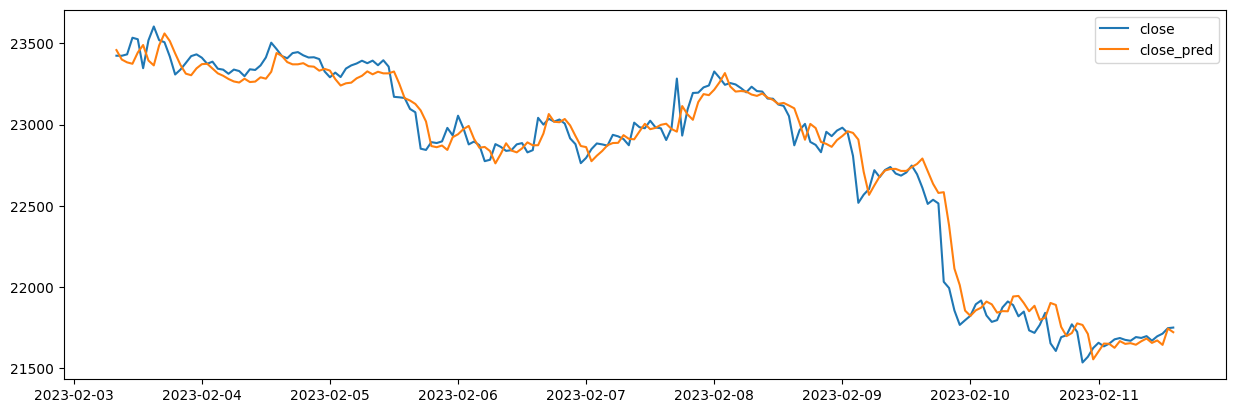

In [14]:
# plot the actual and predicted values
plt.figure().set_figwidth(15)
plt.plot(y_pred_df[['close','close_pred']], label=['close','close_pred'])
#plt.plot(next_day_full_df[['close','close_pred']], label=['close_n','close_pred_n'])
plt.legend()
plt.show()
